# Pneumonia_Chest_X-Ray

CNN image detection of pneumonia from chest xrays.  
Project By: [Uzair Bin Asim](https://github.com/Uzair05)

In [1]:
import os 
import zipfile

## Download dataset

In [ ]:
#!pip install --upgrade kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [ ]:
try:
    if not os.path.isdir("./data"):
        os.mkdir("./data")
except Exception as err:
    print(f"Error in creating data/:\t{err}")

if os.path.isfile("./chest-xray-pneumonia.zip"):
    localzip = "./chest-xray-pneumonia.zip"
    with zipfile.ZipFile(localzip, 'r') as zip_ref:
        zip_ref.extractall('data/')

In [ ]:
## Clean the dataspace
# !rm -rf data/chest_xray/__MACOSX
# !cd data/ && find -type f | grep -E "\.DS_Store" | xargs -I{} rm {}

## Handle Data
Create the train, test, and validation datasets.

In [ ]:
#!pip install --upgrade tensorflow-gpu==2.4.1

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

print(tf.__version__)

2.4.1


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
main_path = "data/chest_xray/chest_xray"

test_dir, train_dir = os.path.join(main_path, "test"), os.path.join(main_path, "train")
validation_dir = os.path.join(main_path, "val") 

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0, 
    rotation_range=10, 
    width_shift_range=0.3, 
    height_shift_range=0.3, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)
val_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150,150), 
    class_mode='binary', 
    batch_size=60
)
test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(150,150), 
    class_mode='binary', 
    batch_size=20
)
val_generator = val_datagen.flow_from_directory(
    validation_dir, 
    target_size=(150,150), 
    class_mode='binary', 
    batch_size=20
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Create Model - v2

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu, padding='same', input_shape=(150,150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model.compile(
    #optimizer='adam', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    #loss="binary_crossentropy", 
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 87616)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               4

## Train Model - v1

In [8]:
class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        accuracy = 0.95 # Percentage Accuracy.
        if(logs.get('accuracy') != None) and (logs.get('accuracy') >= accuracy): # Experiment with changing this value
          print(f"\nReached {accuracy*100}% accuracy so cancelling training!")
          self.model.stop_training = True

callbacks = myCallback()

In [9]:
history = model.fit(
    train_generator, 
    validation_data = test_generator,
    steps_per_epoch = 85, 
    epochs = 30,
    validation_steps = 30,
    verbose = 1, 
    callbacks=[callbacks]
)

Epoch 1/30
85/85 [==============================] - 126s 1s/step - loss: 0.5832 - accuracy: 0.7342 - val_loss: 0.6186 - val_accuracy: 0.6250
Epoch 2/30
85/85 [==============================] - 124s 1s/step - loss: 0.4521 - accuracy: 0.7821 - val_loss: 0.4541 - val_accuracy: 0.7933
Epoch 3/30
85/85 [==============================] - 123s 1s/step - loss: 0.3403 - accuracy: 0.8426 - val_loss: 0.3581 - val_accuracy: 0.8467
Epoch 4/30
85/85 [==============================] - 124s 1s/step - loss: 0.2909 - accuracy: 0.8697 - val_loss: 0.3645 - val_accuracy: 0.8233
Epoch 5/30
85/85 [==============================] - 124s 1s/step - loss: 0.2605 - accuracy: 0.8895 - val_loss: 0.3337 - val_accuracy: 0.8550
Epoch 6/30
85/85 [==============================] - 124s 1s/step - loss: 0.2552 - accuracy: 0.8875 - val_loss: 0.3490 - val_accuracy: 0.8650
Epoch 7/30
85/85 [==============================] - 122s 1s/step - loss: 0.2317 - accuracy: 0.9066 - val_loss: 0.3437 - val_accuracy: 0.8783
Epoch 8/30
85

## Evaluation

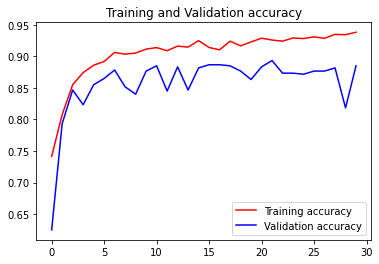

<Figure size 432x288 with 0 Axes>

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [11]:
print(f"Evaluation accuracy with validation dataset:\t{model.evaluate(val_generator)[-1]*100}%")

1/1 [==============================] - 0s 338ms/step - loss: 0.6028 - accuracy: 0.7500
Evaluation accuracy with validation dataset:	75.0%


## Save Model

In [ ]:
#tf.keras.models.save_model(model, filepath="./my_model/OwnCNN_EfficientNetB3_99p.h5", overwrite=True, save_format='h5')